In [25]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# 定义一些参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'gan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
## Image processing
trans = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize([0.5],[0.5])
])

## MNIST dataset
mnist = torchvision.datasets.MNIST(root = 'data',
                                  train = True,
                                  transform = trans,
                                  download=False)

# data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size = batch_size,
                                         shuffle=True)

In [6]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

# 构建生成器，这个相当于vae中的解码器
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

## 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

## 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

#Clamp函数x限制在区间[min,max]内
def denorm(x):
    out = (x + 1) /2
    return out.clamp(0,1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
# 开始训练
total_step = len(data_loader)

In [23]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size,-1).to(device)
        
        #定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #
        
        # 定义判断其对真图片的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs,real_labels)
        real_score = outputs
        
        # 定义判别器对假设图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size,latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        ## 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake
        
        # 对生成器、判别器的梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #
        
        # 定义生成器对假图片的损失函数，这里我们要求
        # 判别器生成的图片越来越像真图片，故损失函数中
        # 的标签改为真图片的标签，即希望生成的假图片，
        # 越来越靠近真图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs,real_labels)
        
        ## 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 ==0:
            print('Epoch[{}/{}], Step[{}/{}], d_loss:{:.4f}, g_loss:{:.4f},D(x): {:.2f}, D(G(z)): {:.2f}'
                 .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                         real_score.mean().item(), fake_score.mean().item()))
            
            
    # 保存真图片
    if (epoch + 1)==1:
        images = images.reshape(images.size(0),1,28,28)
        save_image(denorm(images),os.path.join(sample_dir,'real_images.png'))
        
    
    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_image-{}.png'.format(epoch+1)))
    
# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')
        

Epoch[0/200], Step[200/600], d_loss:0.8351, g_loss:1.9774,D(x): 0.69, D(G(z)): 0.26
Epoch[0/200], Step[400/600], d_loss:1.0062, g_loss:1.4220,D(x): 0.62, D(G(z)): 0.28
Epoch[0/200], Step[600/600], d_loss:0.9529, g_loss:1.6076,D(x): 0.67, D(G(z)): 0.32
Epoch[1/200], Step[200/600], d_loss:0.9870, g_loss:1.4155,D(x): 0.66, D(G(z)): 0.30
Epoch[1/200], Step[400/600], d_loss:0.7977, g_loss:1.9828,D(x): 0.70, D(G(z)): 0.26
Epoch[1/200], Step[600/600], d_loss:0.9124, g_loss:1.6677,D(x): 0.70, D(G(z)): 0.30
Epoch[2/200], Step[200/600], d_loss:0.9046, g_loss:1.8242,D(x): 0.64, D(G(z)): 0.24
Epoch[2/200], Step[400/600], d_loss:0.9519, g_loss:1.3606,D(x): 0.70, D(G(z)): 0.34
Epoch[2/200], Step[600/600], d_loss:0.8369, g_loss:1.5776,D(x): 0.69, D(G(z)): 0.27
Epoch[3/200], Step[200/600], d_loss:0.7663, g_loss:1.6092,D(x): 0.74, D(G(z)): 0.29
Epoch[3/200], Step[400/600], d_loss:0.8344, g_loss:1.4714,D(x): 0.73, D(G(z)): 0.31
Epoch[3/200], Step[600/600], d_loss:0.9810, g_loss:1.5394,D(x): 0.66, D(G(z)

Epoch[32/200], Step[400/600], d_loss:1.0686, g_loss:1.2463,D(x): 0.67, D(G(z)): 0.37
Epoch[32/200], Step[600/600], d_loss:0.9311, g_loss:1.3771,D(x): 0.70, D(G(z)): 0.33
Epoch[33/200], Step[200/600], d_loss:1.0825, g_loss:1.5540,D(x): 0.67, D(G(z)): 0.36
Epoch[33/200], Step[400/600], d_loss:1.0116, g_loss:1.4973,D(x): 0.65, D(G(z)): 0.29
Epoch[33/200], Step[600/600], d_loss:0.8827, g_loss:1.5063,D(x): 0.67, D(G(z)): 0.23
Epoch[34/200], Step[200/600], d_loss:0.7816, g_loss:1.6965,D(x): 0.72, D(G(z)): 0.25
Epoch[34/200], Step[400/600], d_loss:1.1134, g_loss:1.5011,D(x): 0.55, D(G(z)): 0.26
Epoch[34/200], Step[600/600], d_loss:0.9597, g_loss:1.4601,D(x): 0.68, D(G(z)): 0.30
Epoch[35/200], Step[200/600], d_loss:1.0793, g_loss:1.2933,D(x): 0.65, D(G(z)): 0.34
Epoch[35/200], Step[400/600], d_loss:0.9850, g_loss:1.2931,D(x): 0.62, D(G(z)): 0.24
Epoch[35/200], Step[600/600], d_loss:0.8797, g_loss:1.5172,D(x): 0.73, D(G(z)): 0.32
Epoch[36/200], Step[200/600], d_loss:1.1262, g_loss:1.6846,D(x): 

Epoch[64/200], Step[600/600], d_loss:1.1045, g_loss:1.2569,D(x): 0.74, D(G(z)): 0.42
Epoch[65/200], Step[200/600], d_loss:0.8957, g_loss:1.6244,D(x): 0.70, D(G(z)): 0.29
Epoch[65/200], Step[400/600], d_loss:0.9587, g_loss:1.3714,D(x): 0.78, D(G(z)): 0.42
Epoch[65/200], Step[600/600], d_loss:0.8468, g_loss:1.7276,D(x): 0.70, D(G(z)): 0.29
Epoch[66/200], Step[200/600], d_loss:1.0487, g_loss:1.4197,D(x): 0.64, D(G(z)): 0.31
Epoch[66/200], Step[400/600], d_loss:0.9929, g_loss:1.5976,D(x): 0.67, D(G(z)): 0.33
Epoch[66/200], Step[600/600], d_loss:0.8323, g_loss:1.6663,D(x): 0.69, D(G(z)): 0.25
Epoch[67/200], Step[200/600], d_loss:0.7972, g_loss:1.6154,D(x): 0.74, D(G(z)): 0.29
Epoch[67/200], Step[400/600], d_loss:0.8541, g_loss:1.5431,D(x): 0.71, D(G(z)): 0.29
Epoch[67/200], Step[600/600], d_loss:1.1051, g_loss:1.4666,D(x): 0.59, D(G(z)): 0.26
Epoch[68/200], Step[200/600], d_loss:0.9943, g_loss:1.4912,D(x): 0.67, D(G(z)): 0.32
Epoch[68/200], Step[400/600], d_loss:1.0463, g_loss:1.3766,D(x): 

Epoch[97/200], Step[200/600], d_loss:1.0987, g_loss:1.7589,D(x): 0.69, D(G(z)): 0.34
Epoch[97/200], Step[400/600], d_loss:0.9508, g_loss:1.2606,D(x): 0.70, D(G(z)): 0.35
Epoch[97/200], Step[600/600], d_loss:0.8667, g_loss:1.5737,D(x): 0.74, D(G(z)): 0.32
Epoch[98/200], Step[200/600], d_loss:0.8789, g_loss:1.8520,D(x): 0.71, D(G(z)): 0.30
Epoch[98/200], Step[400/600], d_loss:1.0001, g_loss:1.3654,D(x): 0.66, D(G(z)): 0.33
Epoch[98/200], Step[600/600], d_loss:0.8886, g_loss:1.5601,D(x): 0.69, D(G(z)): 0.30
Epoch[99/200], Step[200/600], d_loss:0.9661, g_loss:1.3976,D(x): 0.68, D(G(z)): 0.32
Epoch[99/200], Step[400/600], d_loss:0.9686, g_loss:1.4112,D(x): 0.68, D(G(z)): 0.31
Epoch[99/200], Step[600/600], d_loss:1.0080, g_loss:1.5980,D(x): 0.64, D(G(z)): 0.30
Epoch[100/200], Step[200/600], d_loss:0.8302, g_loss:1.3318,D(x): 0.72, D(G(z)): 0.30
Epoch[100/200], Step[400/600], d_loss:1.1031, g_loss:1.7539,D(x): 0.55, D(G(z)): 0.20
Epoch[100/200], Step[600/600], d_loss:0.9888, g_loss:1.4191,D(x

Epoch[129/200], Step[200/600], d_loss:0.9525, g_loss:1.8074,D(x): 0.66, D(G(z)): 0.30
Epoch[129/200], Step[400/600], d_loss:0.8548, g_loss:1.3899,D(x): 0.67, D(G(z)): 0.25
Epoch[129/200], Step[600/600], d_loss:1.0399, g_loss:1.6091,D(x): 0.69, D(G(z)): 0.36
Epoch[130/200], Step[200/600], d_loss:0.8258, g_loss:1.5442,D(x): 0.74, D(G(z)): 0.29
Epoch[130/200], Step[400/600], d_loss:0.9533, g_loss:1.4386,D(x): 0.67, D(G(z)): 0.28
Epoch[130/200], Step[600/600], d_loss:1.0906, g_loss:1.2846,D(x): 0.70, D(G(z)): 0.35
Epoch[131/200], Step[200/600], d_loss:1.0018, g_loss:1.4915,D(x): 0.65, D(G(z)): 0.31
Epoch[131/200], Step[400/600], d_loss:1.0635, g_loss:1.6118,D(x): 0.68, D(G(z)): 0.36
Epoch[131/200], Step[600/600], d_loss:0.9518, g_loss:1.3481,D(x): 0.71, D(G(z)): 0.32
Epoch[132/200], Step[200/600], d_loss:1.0926, g_loss:1.3719,D(x): 0.74, D(G(z)): 0.44
Epoch[132/200], Step[400/600], d_loss:0.9737, g_loss:1.3726,D(x): 0.66, D(G(z)): 0.30
Epoch[132/200], Step[600/600], d_loss:0.8809, g_loss:1

Epoch[161/200], Step[200/600], d_loss:0.8415, g_loss:1.5448,D(x): 0.73, D(G(z)): 0.29
Epoch[161/200], Step[400/600], d_loss:0.9844, g_loss:1.5784,D(x): 0.70, D(G(z)): 0.33
Epoch[161/200], Step[600/600], d_loss:0.8542, g_loss:1.3101,D(x): 0.69, D(G(z)): 0.28
Epoch[162/200], Step[200/600], d_loss:0.8738, g_loss:1.4580,D(x): 0.75, D(G(z)): 0.32
Epoch[162/200], Step[400/600], d_loss:0.8078, g_loss:1.7250,D(x): 0.77, D(G(z)): 0.31
Epoch[162/200], Step[600/600], d_loss:0.8010, g_loss:1.3437,D(x): 0.79, D(G(z)): 0.34
Epoch[163/200], Step[200/600], d_loss:0.8707, g_loss:1.6943,D(x): 0.67, D(G(z)): 0.26
Epoch[163/200], Step[400/600], d_loss:1.1017, g_loss:1.2291,D(x): 0.73, D(G(z)): 0.39
Epoch[163/200], Step[600/600], d_loss:0.9708, g_loss:1.3451,D(x): 0.71, D(G(z)): 0.34
Epoch[164/200], Step[200/600], d_loss:0.9752, g_loss:1.5717,D(x): 0.70, D(G(z)): 0.32
Epoch[164/200], Step[400/600], d_loss:0.8818, g_loss:1.6957,D(x): 0.75, D(G(z)): 0.33
Epoch[164/200], Step[600/600], d_loss:0.8513, g_loss:1

Epoch[193/200], Step[200/600], d_loss:0.9215, g_loss:1.8407,D(x): 0.65, D(G(z)): 0.24
Epoch[193/200], Step[400/600], d_loss:0.8973, g_loss:1.6694,D(x): 0.77, D(G(z)): 0.35
Epoch[193/200], Step[600/600], d_loss:0.9429, g_loss:1.8454,D(x): 0.66, D(G(z)): 0.29
Epoch[194/200], Step[200/600], d_loss:0.9122, g_loss:1.6751,D(x): 0.72, D(G(z)): 0.31
Epoch[194/200], Step[400/600], d_loss:0.9125, g_loss:1.2591,D(x): 0.67, D(G(z)): 0.27
Epoch[194/200], Step[600/600], d_loss:0.9281, g_loss:1.6582,D(x): 0.75, D(G(z)): 0.34
Epoch[195/200], Step[200/600], d_loss:0.9538, g_loss:1.6432,D(x): 0.66, D(G(z)): 0.26
Epoch[195/200], Step[400/600], d_loss:1.0833, g_loss:1.5294,D(x): 0.56, D(G(z)): 0.24
Epoch[195/200], Step[600/600], d_loss:0.8774, g_loss:1.5687,D(x): 0.73, D(G(z)): 0.31
Epoch[196/200], Step[200/600], d_loss:0.8354, g_loss:2.0284,D(x): 0.72, D(G(z)): 0.27
Epoch[196/200], Step[400/600], d_loss:0.9642, g_loss:1.4025,D(x): 0.76, D(G(z)): 0.38
Epoch[196/200], Step[600/600], d_loss:0.9834, g_loss:1

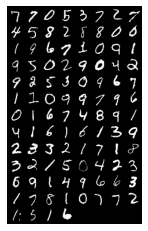

In [26]:
reconsPath = './gan_samples/real_images.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image)#显示图片
plt.axis('off')
plt.show()

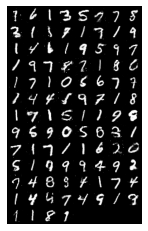

In [28]:
reconsPath = './gan_samples/fake_image-200.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image)#显示图片
plt.axis('off')#不显示坐标轴
plt.show()